In [2]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import pandas as pd
from matplotlib.patches import Patch





**Data Plotting**

/opt/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


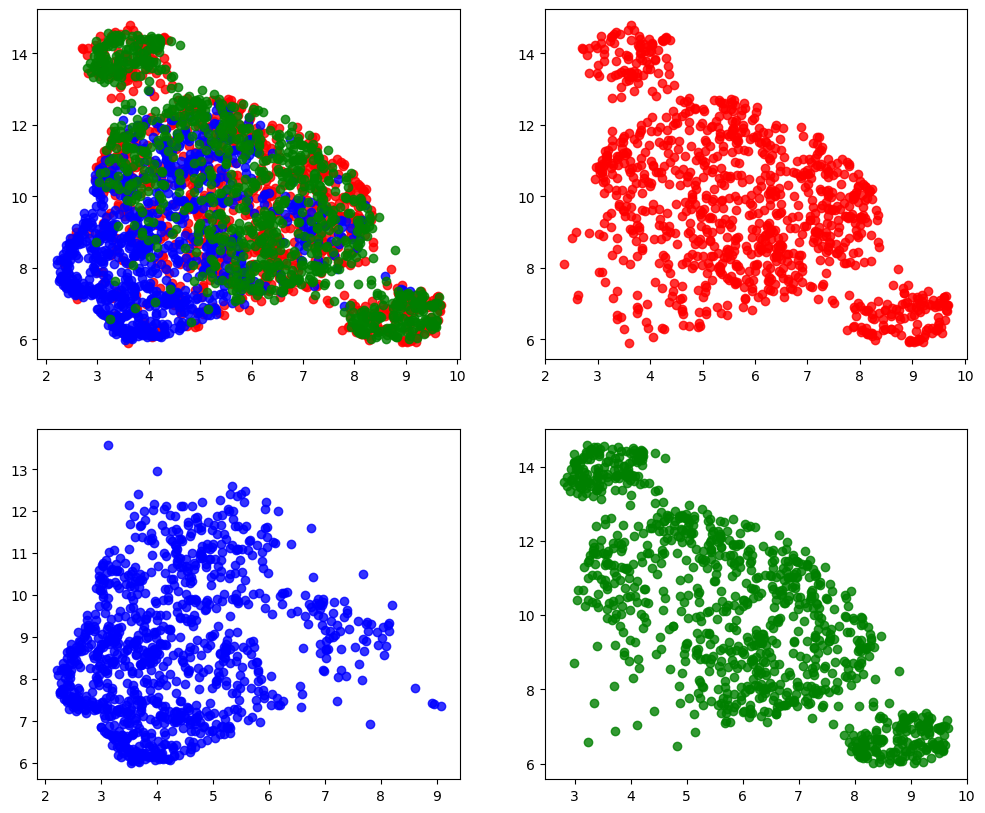

In [7]:
feature_space = torch.load("/workspaces/dbm25/data/extracted_features.pt")


label = "brain_menin"
feature = "hog"

# feature_list = [elem[feature].flatten().numpy() for elem in feature_space if elem["class"] == label]
feature_list = [elem[feature].flatten().numpy() for elem in feature_space]


# Configurazione di UMAP
reducer = UMAP(
    n_components=2,     
    n_neighbors=50,      
    min_dist=0.2,        
    metric='euclidean',  
    random_state=42      
)

# Trasformazione
# Se hai un singolo esempio
embedded_data = reducer.fit_transform(feature_list)

df = pd.DataFrame(embedded_data, columns=["x", "y"])
df["label"] = [elem["class"] for elem in feature_space]

brain_menin_df = df[df['label'] == "brain_menin"]
brain_tumor_df = df[df['label'] == "brain_tumor"]
brain_glioma_df = df[df['label'] == "brain_glioma"]


fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(brain_menin_df.x, brain_menin_df.y, alpha=0.8, c='red')
axs[0, 0].scatter(brain_tumor_df.x, brain_tumor_df.y, alpha=0.8, c='blue')
axs[0, 0].scatter(brain_glioma_df.x, brain_glioma_df.y, alpha=0.8, c='green')

axs[0, 1].scatter(brain_menin_df.x, brain_menin_df.y, alpha=0.8, c='red')
axs[1, 0].scatter(brain_tumor_df.x, brain_tumor_df.y, alpha=0.8, c='blue')
axs[1, 1].scatter(brain_glioma_df.x, brain_glioma_df.y, alpha=0.8, c='green')


"""
plt.scatter(brain_menin_df.x, brain_menin_df.y, alpha=0.8, c='red')
plt.scatter(brain_tumor_df.x, brain_tumor_df.y, alpha=0.8, c='blue')
plt.scatter(brain_glioma_df.x, brain_glioma_df.y, alpha=0.8, c='green')
plt.title('Proiezione UMAP 2D')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Crea le voci della legenda
legend_elements = [
    Patch(facecolor='red', label='Brain Menim'),
    Patch(facecolor='blue', label='Brain Tumor'),
    Patch(facecolor='green', label='Brain Glioma'),
]

plt.legend(handles=legend_elements, title='Legenda')

"""
plt.show()

In [ ]:
feature_space = torch.load("/workspaces/dbm25/data/extracted_features.pt")

label = "brain_menin"

feature_list = [elem["layer3"].numpy() for elem in feature_space if elem["class"] == label]

feature_array = np.array(feature_list)


clustering = DBSCAN(eps=10100, min_samples=1).fit(feature_array)
labels = clustering.labels_
n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
print(labels.tolist())
print(n_cluster)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 